In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset
df = pd.read_csv('water_potability.csv')  # if in the same folder

# Separate predictors and target
X_raw = df.drop(columns=['Potability'])
y = df['Potability']

# Impute missing values with global mean
imp = SimpleImputer(strategy='mean')
X_filled = pd.DataFrame(
    imp.fit_transform(X_raw),
    columns=X_raw.columns,
    index=X_raw.index
)

# Create all second-degree polynomial terms (exclude bias)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_filled)

# Clean up feature names for readability
feat_names = poly.get_feature_names_out(X_raw.columns)
clean_names = [n.replace(' ', '_').replace('^2', '_pow2') for n in feat_names]
X_poly_df = pd.DataFrame(X_poly, columns=clean_names, index=X_raw.index)

# Identify squared terms and interaction terms
square_cols = [c for c in clean_names if c.endswith('_pow2')]
interaction_cols = [
    c for c in clean_names
    if c not in X_raw.columns and c not in square_cols
]

# Select top 9 interaction terms by absolute correlation with the target
corrs = (
    X_poly_df[interaction_cols]
    .corrwith(y)
    .abs()
    .sort_values(ascending=False)
)
top9_interacts = corrs.head(9).index.tolist()

# Assemble the engineered feature matrix
X_engineered = pd.concat(
    [
        X_raw,                      # original features
        X_poly_df[square_cols],     # squared terms
        X_poly_df[top9_interacts]   # strongest interactions
    ],
    axis=1
)

print(f"Engineered feature matrix: {X_engineered.shape}")
X = X_engineered


Engineered feature matrix: (3276, 27)


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    FunctionTransformer,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 1. Split first to avoid information leakage
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42,
)

# 2. Global mean imputation (ensures no missing values in numeric features)
imputer = SimpleImputer(strategy='mean')

# 3. Custom transformations to address skewness and heavy tails
#    - ph, Hardness, Conductivity, Organic_carbon: Yeo–Johnson (de-skew)
#    - Solids, Sulfate, Trihalomethanes: log1p (heavy tail)
#    - Chloramines, Turbidity: sqrt (mild right skew)
pt = PowerTransformer(method='yeo-johnson', standardize=False)
log1p_tf = FunctionTransformer(np.log1p, validate=False)
sqrt_tf = FunctionTransformer(np.sqrt, validate=False)

# 4. Build the ColumnTransformer pipeline
preprocessor = ColumnTransformer(
    [
        # Yeo–Johnson group
        (
            'yj_num',
            Pipeline(
                [
                    ('imp', imputer),
                    ('pt', pt),
                    ('std', StandardScaler()),
                ]
            ),
            ['ph', 'Hardness', 'Conductivity', 'Organic_carbon'],
        ),
        # log1p group
        (
            'log_num',
            Pipeline(
                [
                    ('imp', imputer),
                    ('log', log1p_tf),
                    ('std', StandardScaler()),
                ]
            ),
            ['Solids', 'Sulfate', 'Trihalomethanes'],
        ),
        # sqrt group
        (
            'sqrt_num',
            Pipeline(
                [
                    ('imp', imputer),
                    ('sqrt', sqrt_tf),
                    ('std', StandardScaler()),
                ]
            ),
            ['Chloramines', 'Turbidity'],
        ),
        # Potability label is not transformed; it is dropped here
    ],
    remainder='drop',
)

# 5. Fit and transform
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# 6. Quick sanity checks
print("Transformed shape:", X_train.shape)
print(
    "First feature mean/std:",
    np.round(X_train.mean(axis=0)[:4], 3),
    np.round(X_train.std(axis=0)[:4], 3),
)


Transformed shape: (2620, 9)
First feature mean/std: [ 0. -0. -0. -0.] [1. 1. 1. 1.]


         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.080795  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  333.775777    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  333.775777    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  -

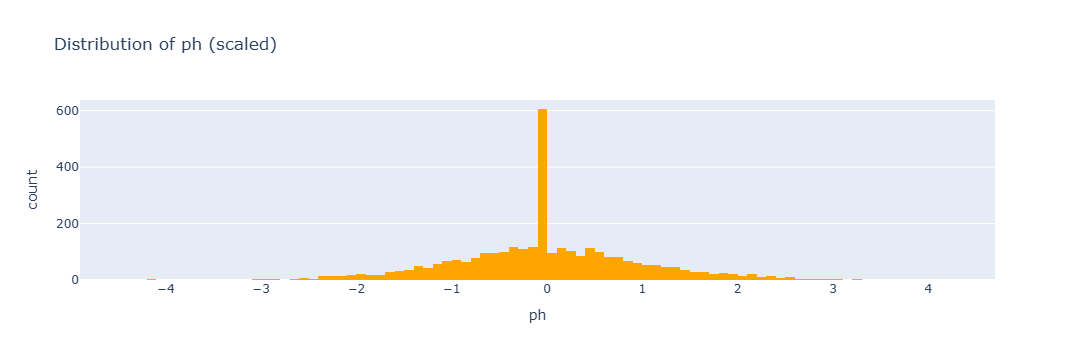

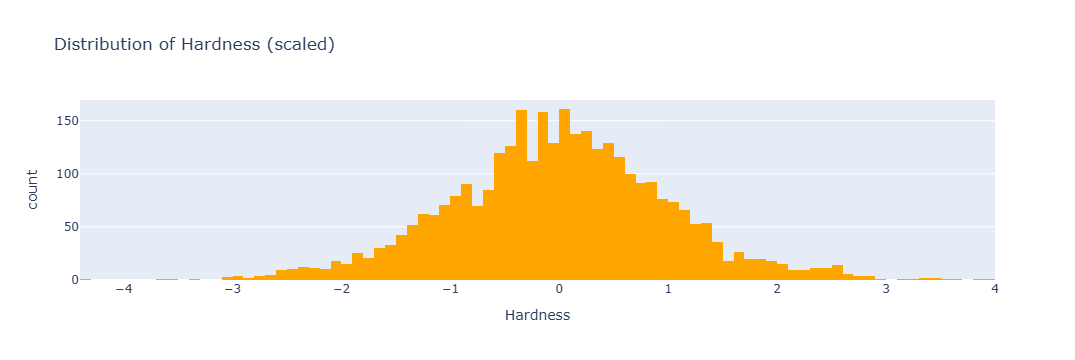

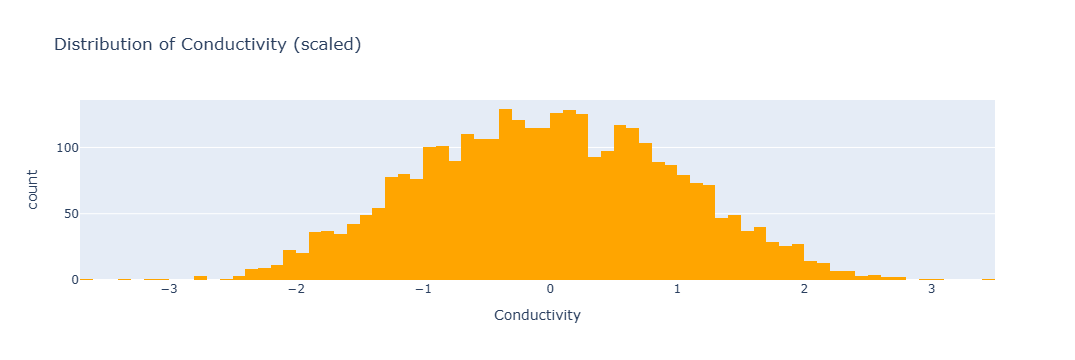

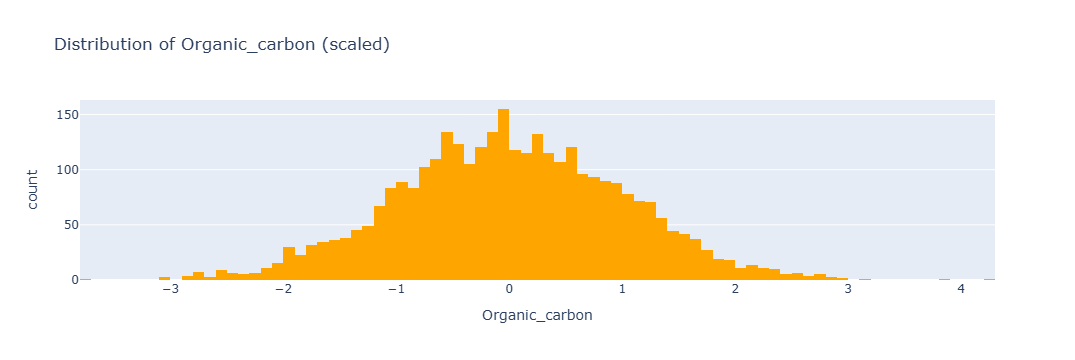

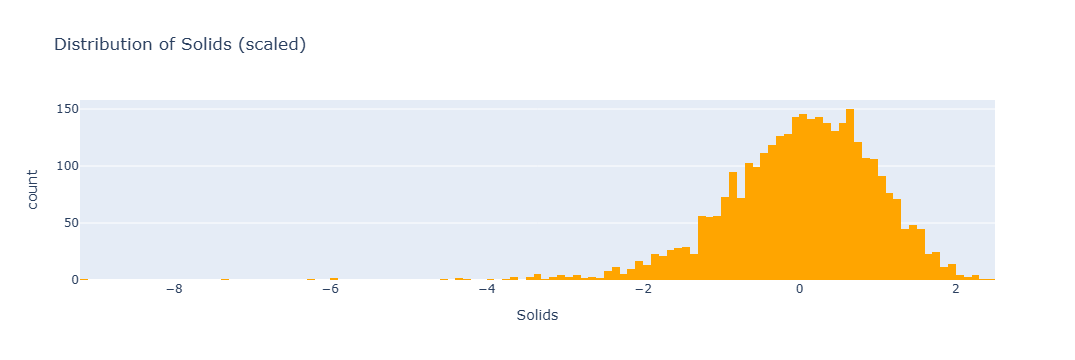

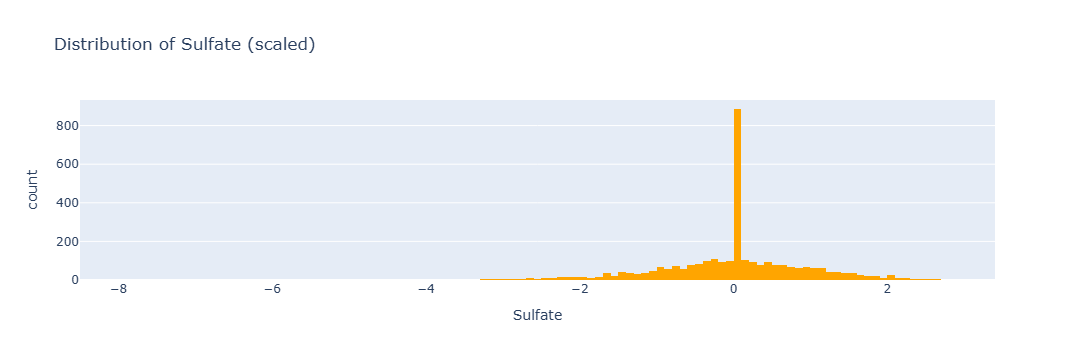

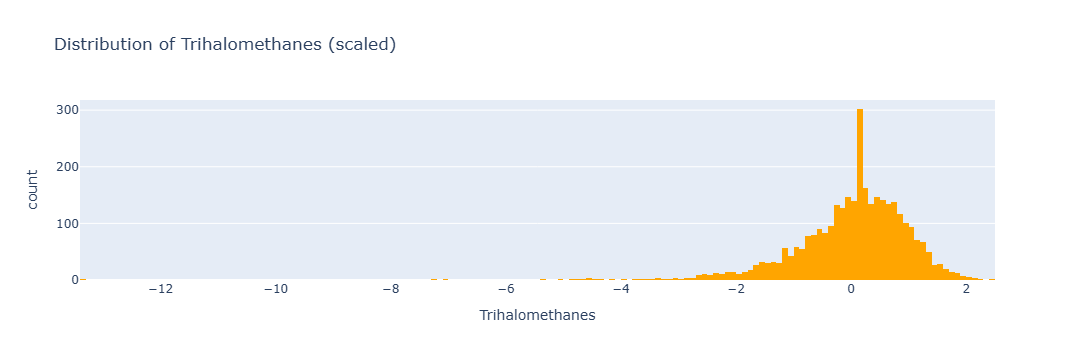

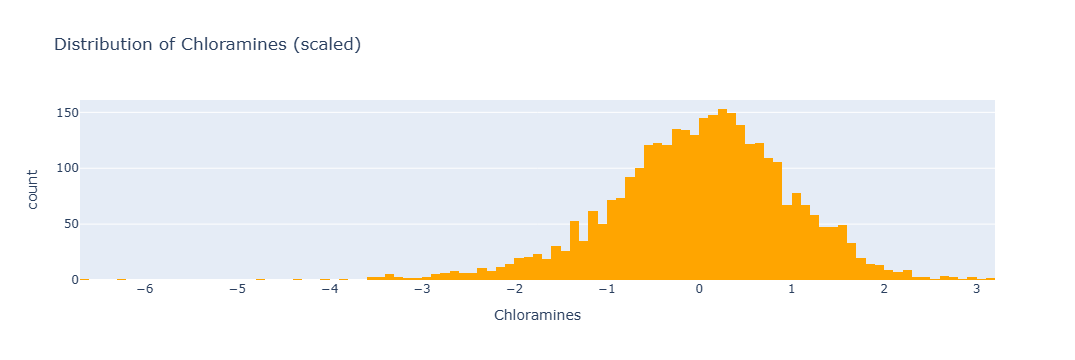

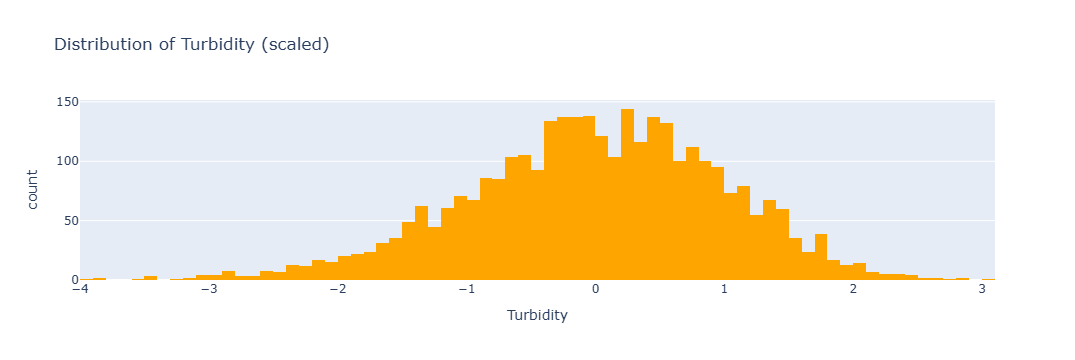

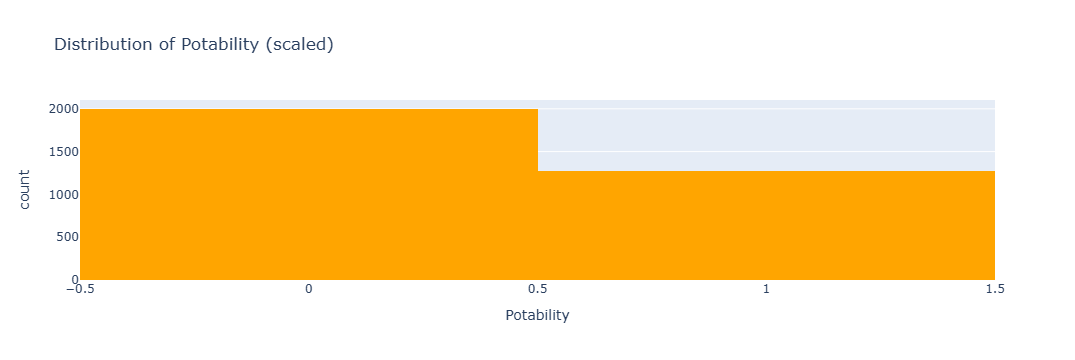

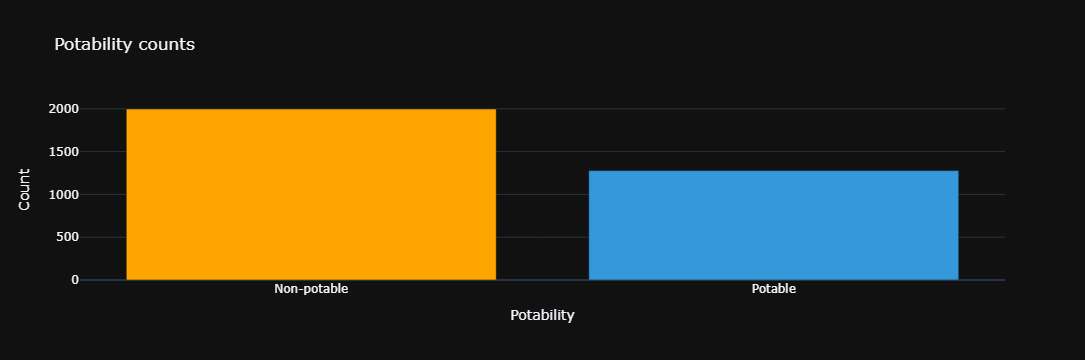

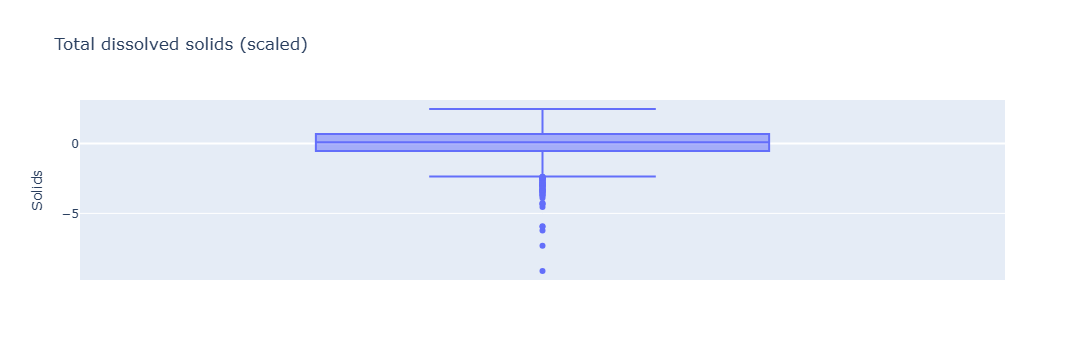

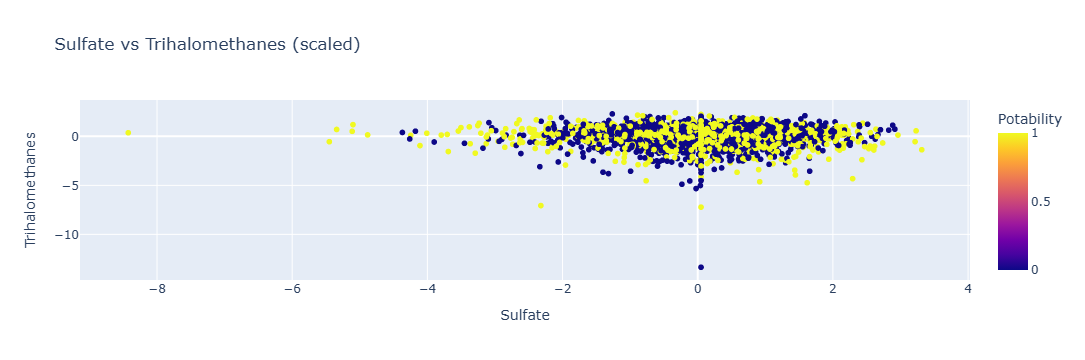

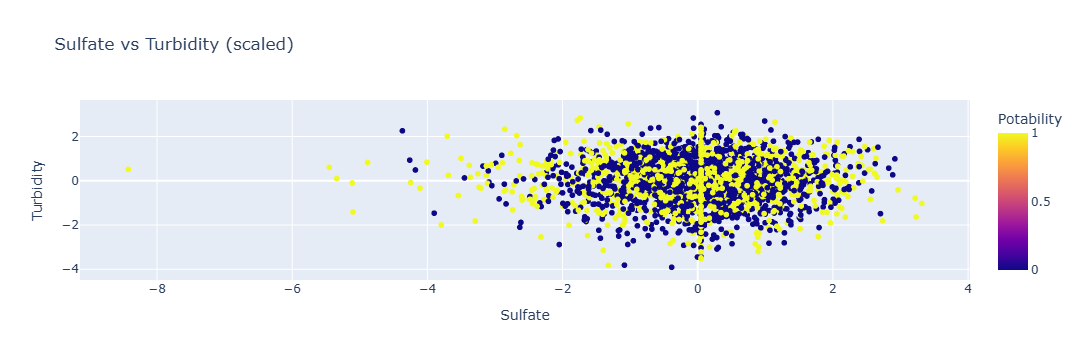

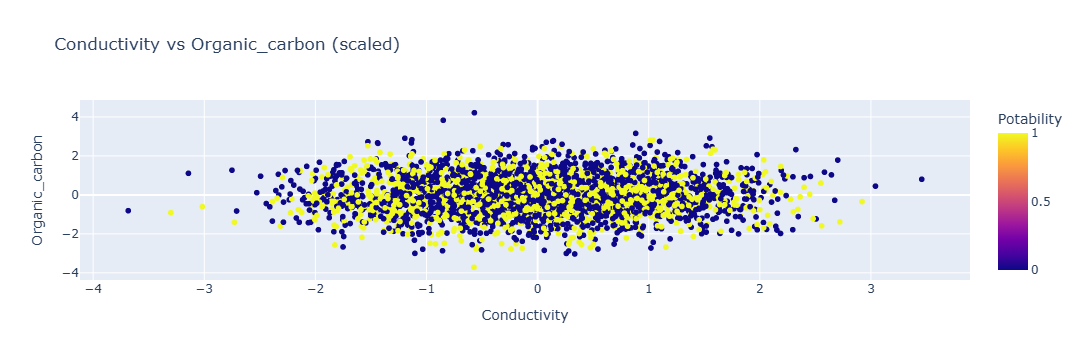

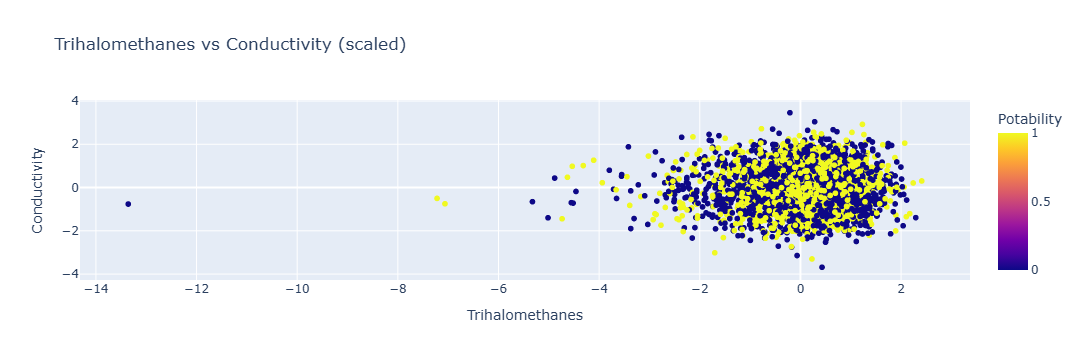

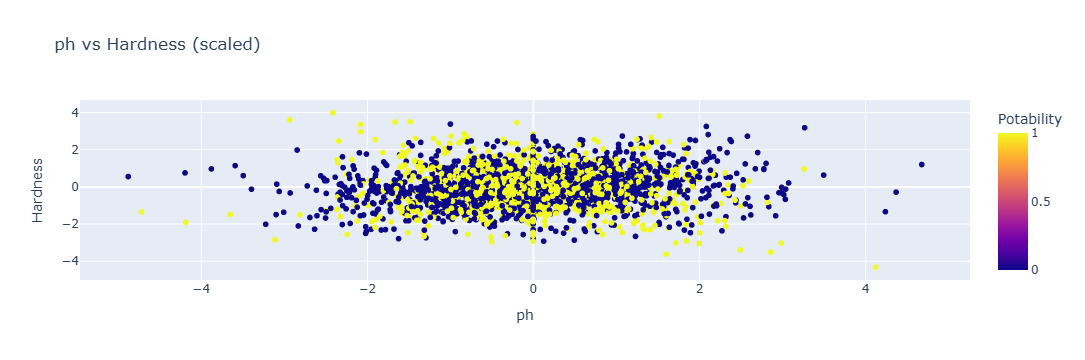

ImportError: cannot import name '_lazywhere' from 'scipy._lib._util' (C:\Users\User\anaconda3\envs\ml\Lib\site-packages\scipy\_lib\_util.py)

In [6]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer

# 1. Inspect basic structure and summary statistics
print(df.head())
df.info()
print(df.describe())

# 2. Summarize missing values and perform mean imputation
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing by column:\n", missing[missing > 0])

if missing.sum() > 0:
    fig = go.Figure(
        data=[
            go.Pie(
                labels=missing.index,
                values=missing.values,
                hole=0.4,
                marker=dict(
                    colors=['orange', 'lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
                ),
            )
        ]
    )
    fig.update_traces(textinfo='percent+label')
    fig.update_layout(title='Missing-value distribution')
    fig.show()

    imp = SimpleImputer(strategy='mean')
    for col in missing[missing > 0].index:
        df[col] = imp.fit_transform(df[[col]])
    print("Post-imputation:\n", df.isnull().sum())

# 3. Build a scaled and transformed DataFrame for visualizations
#    (uses the pre-fitted `preprocessor` from the feature-engineering cell)
features = [
    'ph',
    'Hardness',
    'Conductivity',
    'Organic_carbon',
    'Solids',
    'Sulfate',
    'Trihalomethanes',
    'Chloramines',
    'Turbidity',
]
scaled_array = preprocessor.transform(df[features])
df_scaled = pd.DataFrame(scaled_array, columns=features, index=df.index)
df_scaled['Potability'] = df['Potability'].values

print("Scaled dataframe preview:")
print(df_scaled.head())

# 4. Univariate distributions (histograms)
for col in df_scaled.select_dtypes(include=['int64', 'float64']).columns:
    fig = px.histogram(df_scaled, x=col, title=f'Distribution of {col} (scaled)')
    fig.update_traces(marker_color='orange')
    fig.show()

# 5. Target distribution (bar chart)
pdist = (
    df_scaled['Potability']
    .value_counts()
    .rename_axis('Pot')
    .reset_index(name='Count')
)
pdist['Pot'] = pdist['Pot'].map({0: 'Non-potable', 1: 'Potable'})
fig = go.Figure(
    go.Bar(
        x=pdist['Pot'],
        y=pdist['Count'],
        marker=dict(color=['orange', '#3498DB']),
    )
)
fig.update_layout(
    title='Potability counts',
    xaxis_title='Potability',
    yaxis_title='Count',
    template='plotly_dark',
)
fig.show()

# 6. Box plot and selected scatter pairs
fig = px.box(df_scaled, y='Solids', title='Total dissolved solids (scaled)')
fig.show()

pairs = [
    ('Sulfate', 'Trihalomethanes'),
    ('Sulfate', 'Turbidity'),
    ('Conductivity', 'Organic_carbon'),
    ('Trihalomethanes', 'Conductivity'),
    ('ph', 'Hardness'),
]
for x, y in pairs:
    fig = px.scatter(
        df_scaled,
        x=x,
        y=y,
        color='Potability',
        title=f'{x} vs {y} (scaled)',
    )
    fig.show()

# 7. Correlation analysis
corr = df_scaled.corr()

fig = px.scatter(
    df_scaled,
    x='Potability',
    y='ph',
    trendline='ols',
    title=f'pH vs Potability (r={corr.loc["ph","Potability"]:.2f})',
)
fig.show()

fig = px.scatter(
    df_scaled,
    x='Potability',
    y='Hardness',
    trendline='ols',
    title=f'Hardness vs Potability (r={corr.loc["Hardness","Potability"]:.2f})',
)
fig.show()

fig = px.imshow(
    corr,
    labels=dict(color='Correlation'),
    x=corr.columns,
    y=corr.index,
    color_continuous_scale='RdBu',
    title='Correlation matrix (scaled)',
)
fig.update_xaxes(side='top')
fig.show()


# 2. Model Training

## Attempt 1: Some base models


-- Model definitions --
Logistic Regression: LogisticRegression(class_weight='balanced', max_iter=1000)
Random Forest: RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)
Linear SVM: SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)
Gradient Boosting: GradientBoostingClassifier(random_state=42)
Neural Net (MLP): MLPClassifier(max_iter=600, random_state=42)

-- Training and evaluation --

-- Evaluation results --
              Model  Accuracy  Precision  Recall     F1  ROC_AUC
      Random Forest    0.6677     0.6827  0.2773 0.3944   0.6654
  Gradient Boosting    0.6570     0.6566  0.2539 0.3662   0.6601
   Neural Net (MLP)    0.6250     0.5260  0.3945 0.4509   0.6326
         Linear SVM    0.5976     0.4794  0.3633 0.4133   0.4544
Logistic Regression    0.5488     0.4383  0.5547 0.4897   0.5584



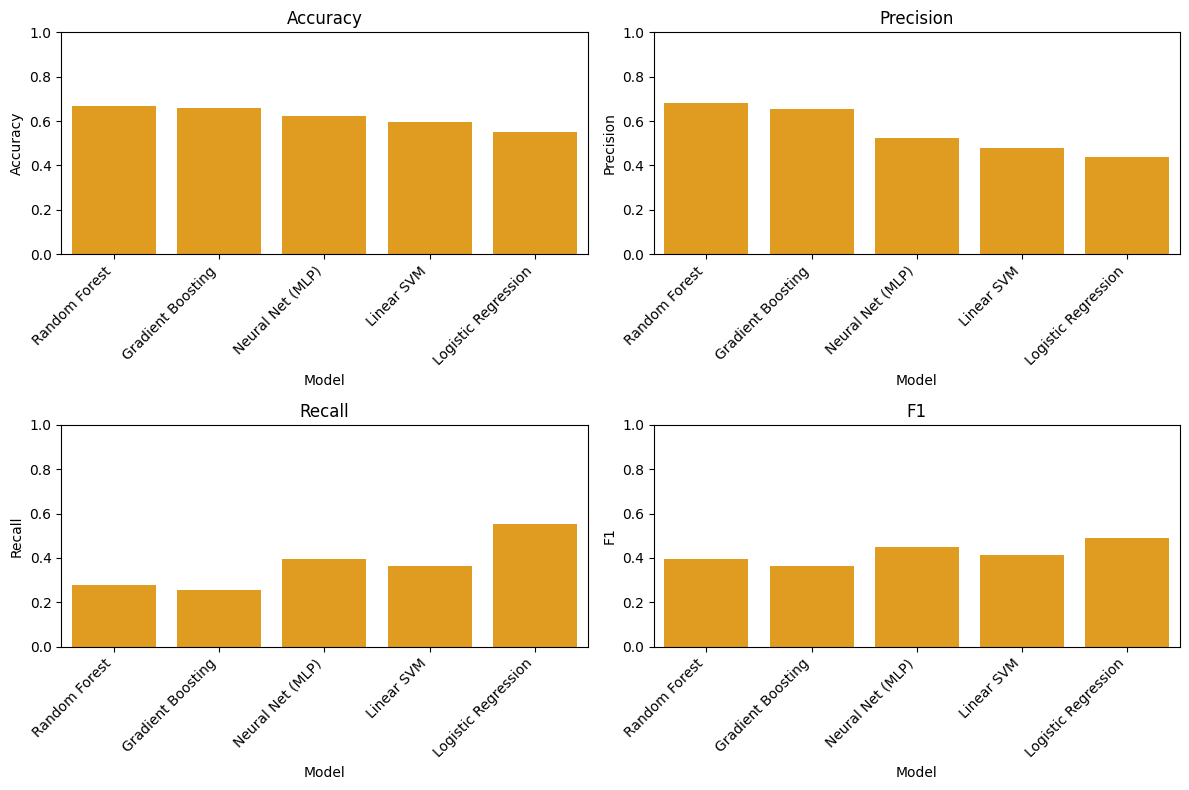

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Define base models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
    ),
    'Linear SVM': SVC(
        kernel='linear',
        probability=True,
        class_weight='balanced',
        random_state=42,
    ),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Net (MLP)': MLPClassifier(max_iter=600, random_state=42),
}

print("\n-- Model definitions --")
for name, model in models.items():
    print(f"{name}: {model}")
print()

# 2. Standardize features (after any resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train and evaluate
print("-- Training and evaluation --\n")

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Obtain probabilities or rescaled decision scores for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        raw = model.decision_function(X_test_scaled)
        y_prob = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append(
        {
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'ROC_AUC': roc_auc_score(y_test, y_prob),
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp,
        }
    )

results_df = (
    pd.DataFrame(results)
    .round(4)
    .sort_values('Accuracy', ascending=False)
    .reset_index(drop=True)
)

print("-- Evaluation results --")
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']].to_string(index=False))
print()

# 4. Visualize key metrics
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Model', y=metric, data=results_df, color='orange')
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Attempt 2. Ensemble Learning


-- Ensemble results --
      Model  Accuracy  Precision  Recall     F1  ROC_AUC
         rf    0.6677     0.6827  0.2773 0.3944   0.6654
voting_soft    0.6662     0.7681  0.2070 0.3262   0.6697
   stacking    0.6631     0.6115  0.3750 0.4649   0.6481
         gb    0.6570     0.6566  0.2539 0.3662   0.6601
        svm    0.5976     0.4794  0.3633 0.4133   0.4544


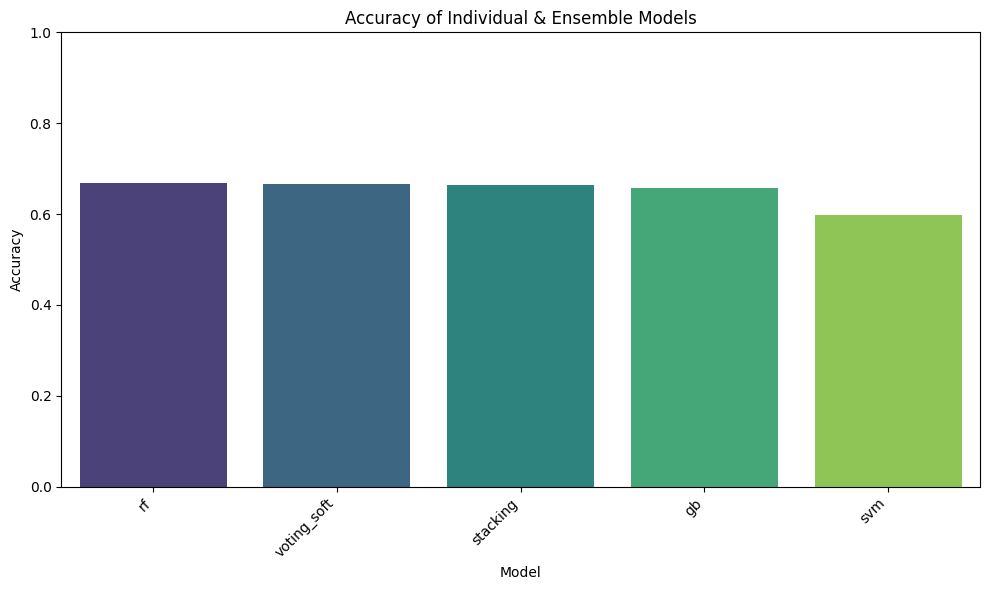

In [8]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

best_single_models = {
    'rf' : models['Random Forest'],
    'gb' : models['Gradient Boosting'],
    'svm': models['Linear SVM'],
}

# Soft-voting ensemble (probability average)

voter = VotingClassifier(
    estimators=[(k, m) for k, m in best_single_models.items()],
    voting='soft',
    weights=[2, 1, 1],               # slightly up-weight Random Forest
    n_jobs=-1
)

# Stacking ensemble
stack = StackingClassifier(
    estimators=[
        ('rf',  models['Random Forest']),
        ('gb',  models['Gradient Boosting']),
        ('svm', models['Linear SVM']),
        ('lr',  models['Logistic Regression']),
    ],
    final_estimator=XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        objective='binary:logistic',
    ),
    n_jobs=-1,
    cv=5,
    passthrough=True,
)


# Fit ensembles

voter.fit(X_train_scaled, y_train)
stack.fit(X_train_scaled, y_train)


# Evaluate everything in one loop
all_models = {
    **best_single_models,
    'voting_soft': voter,
    'stacking'   : stack,
}

metrics = []
for name, mdl in all_models.items():
    y_hat  = mdl.predict(X_test_scaled)
    y_prob = mdl.predict_proba(X_test_scaled)[:, 1]

    metrics.append({
        'Model'     : name,
        'Accuracy'  : accuracy_score(y_test, y_hat),
        'Precision' : precision_score(y_test, y_hat, zero_division=0),
        'Recall'    : recall_score(y_test, y_hat, zero_division=0),
        'F1'        : f1_score(y_test, y_hat, zero_division=0),
        'ROC_AUC'   : roc_auc_score(y_test, y_prob),
    })

results_ens = (
    pd.DataFrame(metrics)
    .round(4)
    .sort_values('Accuracy', ascending=False)
    .reset_index(drop=True)
)

print("\n-- Ensemble results --")
print(results_ens.to_string(index=False))


# Quick visual comparison

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Model', y='Accuracy',
    data=results_ens, palette='viridis'
)
plt.ylim(0, 1)
plt.title('Accuracy of Individual & Ensemble Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Attempt 3. GBMs

In [9]:
# ------------------------------------------------------------
# 0. Imports
# ------------------------------------------------------------
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# ------------------------------------------------------------
# 1. Feature set (re-use the nine core variables)
# ------------------------------------------------------------
FEATURES = [
    'ph', 'Hardness', 'Conductivity', 'Organic_carbon',
    'Solids', 'Sulfate', 'Trihalomethanes', 'Chloramines',
    'Turbidity'
]

X = df_scaled[FEATURES]          # df_scaled was created earlier
y = df_scaled['Potability']

# ------------------------------------------------------------
# 2. Train / test split (stratified, seed = 42)
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# ------------------------------------------------------------
# 3. Define three GBM models with roughly comparable budgets
# ------------------------------------------------------------
models = {
    "CatBoost": CatBoostClassifier(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=10,
        early_stopping_rounds=50,
        auto_class_weights="Balanced",
        random_seed=42,
        task_type="CPU",  # Change to "GPU" if using a GPU
        verbose=False
    ),
    
    # Keep XGBoost and LightGBM entries as they are

    "XGBoost": XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=-1,
        objective="binary",
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
}

# ------------------------------------------------------------
# 4. Fit, predict, and collect metrics
# ------------------------------------------------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # probability scores for ROC-AUC
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.50).astype(int)      # fixed threshold 0.5

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "Model":     name,
        "Accuracy":  accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall":    recall_score(y_test, y_pred, zero_division=0),
        "F1":        f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC":   roc_auc_score(y_test, y_prob),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    })

results_df = (
    pd.DataFrame(results)
    .round(4)
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)

# ------------------------------------------------------------
# 5. Display summary table
# ------------------------------------------------------------
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)

print("\n=== GBM Comparison (seed = 42) ===")
print(results_df[["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]].to_string(index=False))


[LightGBM] [Info] Number of positive: 1022, number of negative: 1598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2620, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

=== GBM Comparison (seed = 42) ===
   Model  Accuracy  Precision  Recall     F1  ROC_AUC
CatBoost    0.6524     0.5593  0.5156 0.5366   0.6655
 XGBoost    0.6463     0.5741  0.3633 0.4450   0.6426
LightGBM    0.6204     0.5169  0.4180 0.4622   0.6332


## Best Result: Seed finding and threshold tuning for catboost

In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# ------------------------------------------------------------------
# 0. Feature matrix and target
# ------------------------------------------------------------------
FEATURES = [
    'ph', 'Hardness', 'Conductivity', 'Organic_carbon',
    'Solids', 'Sulfate', 'Trihalomethanes', 'Chloramines', 'Turbidity',
]
X_full = df_scaled[FEATURES]          # df_scaled was created earlier
y_full = df_scaled['Potability']

# ------------------------------------------------------------------
# 1. Seed loop with “train-or-load” logic
# ------------------------------------------------------------------
results   = []
best_acc  = 0
best_seed = best_thr = best_model = None

for seed in range(10, 21):
    # Train/test split (seed-specific, stratified)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_full,
        y_full,
        test_size=0.20,
        stratify=y_full,
        random_state=seed,
    )

    model_path = Path(f"cat_seed_{seed}.cbm")

    # --- Train or load -------------------------------------------------
    if model_path.exists():
        cat = CatBoostClassifier()          # dummy wrapper for .load_model()
        cat.load_model(str(model_path))
        status = "loaded"
    else:
        cat = CatBoostClassifier(
    task_type="CPU",
    devices="0",
    iterations=800,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=10, # Consider using depth=6 instead of 8. Shallower trees generalize better.
    random_seed=seed,
    auto_class_weights="Balanced",
    eval_metric="Logloss",
    early_stopping_rounds=50,
    metric_period=50,
    verbose=False,
)

        cat.fit(Pool(X_tr, y_tr), eval_set=Pool(X_te, y_te))
        cat.save_model(str(model_path))
        status = "trained"

    # --- Threshold tuning ---------------------------------------------
    proba = cat.predict_proba(X_te)[:, 1]
    fpr, tpr, thr = roc_curve(y_te, proba)
    # Accuracy as a function of threshold (vectorised)
    accs = tpr * y_te.mean() + (1 - fpr) * (1 - y_te.mean())
    idx  = np.argmax(accs)

    thr_best = thr[idx]
    acc_best = accs[idx]

    print(f"[seed {seed:02d}] {status:7s} | thr = {thr_best:.3f} | acc = {acc_best:.3f}")

    results.append(
        {
            "Seed": seed,
            "Threshold": thr_best,
            "Accuracy": acc_best,
            "Trees": cat.tree_count_,
        }
    )

    # Track global best
    if acc_best > best_acc:
        best_acc, best_seed, best_thr, best_model = acc_best, seed, thr_best, cat

# ------------------------------------------------------------------
# 2. Ranked summary
# ------------------------------------------------------------------
summary = (
    pd.DataFrame(results)
    .sort_values("Accuracy", ascending=False)
    .round(4)
    .reset_index(drop=True)
)

print("\n=== Seed-sweep summary (sorted by accuracy) ===")
print(summary.to_string(index=False))

print("\nBest seed   :", best_seed)
print(f"Best thr.   : {best_thr:.3f}")
print(f"Best acc.   : {best_acc:.3f}")
print("Trees used  :", best_model.tree_count_)


[seed 10] trained | thr = 0.591 | acc = 0.684


[seed 11] trained | thr = 0.662 | acc = 0.677


[seed 12] trained | thr = 0.528 | acc = 0.683


[seed 13] trained | thr = 0.591 | acc = 0.697


[seed 14] trained | thr = 0.673 | acc = 0.674


[seed 15] trained | thr = 0.550 | acc = 0.712


[seed 16] trained | thr = 0.533 | acc = 0.703


[seed 17] trained | thr = 0.584 | acc = 0.686


[seed 18] trained | thr = 0.563 | acc = 0.689


[seed 19] trained | thr = 0.550 | acc = 0.701


[seed 20] trained | thr = 0.543 | acc = 0.729

=== Seed-sweep summary (sorted by accuracy) ===
 Seed  Threshold  Accuracy  Trees
   20     0.5428    0.7287    563
   15     0.5501    0.7119    345
   16     0.5326    0.7027    398
   19     0.5500    0.7012    393
   13     0.5909    0.6966    317
   18     0.5626    0.6890    445
   17     0.5839    0.6860    492
   10     0.5906    0.6845    362
   12     0.5283    0.6829    325
   11     0.6624    0.6768    256
   14     0.6733    0.6738    382

Best seed   : 20
Best thr.   : 0.543
Best acc.   : 0.729
Trees used  : 563


# 3. Model Evaluation and Hyperparameter Tuning Using CatBoost

# Improving CatBoost (Tuned)

Precision:	Of all water samples predicted as potable, how many actually were potable? <br>
Recall:	Of all actually potable water samples, how many did the model catch? <br>
F1 Score:	The harmonic mean of precision and recall — balance between false positives and false negatives <br>
Support: How many samples belonged to each class (used to understand balance) <br>

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       400
           1       0.88      0.71      0.78       256

    accuracy                           0.85       656
   macro avg       0.85      0.82      0.83       656
weighted avg       0.85      0.85      0.84       656



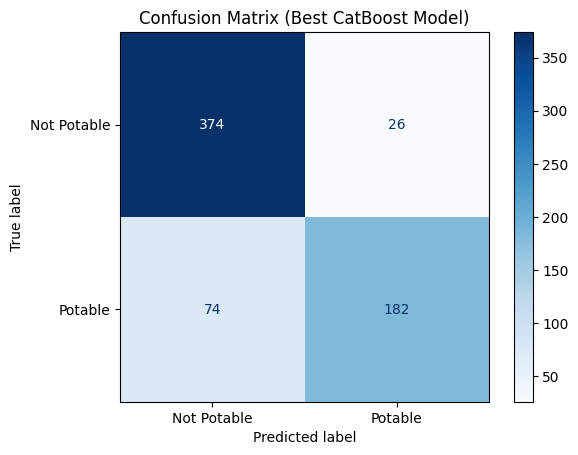

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make thresholded predictions
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_thr).astype(int)

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Potable", "Potable"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best CatBoost Model)")
plt.show()


ROC-AUC gives a threshold-independent measure of how well the model distinguishes potable vs non-potable.

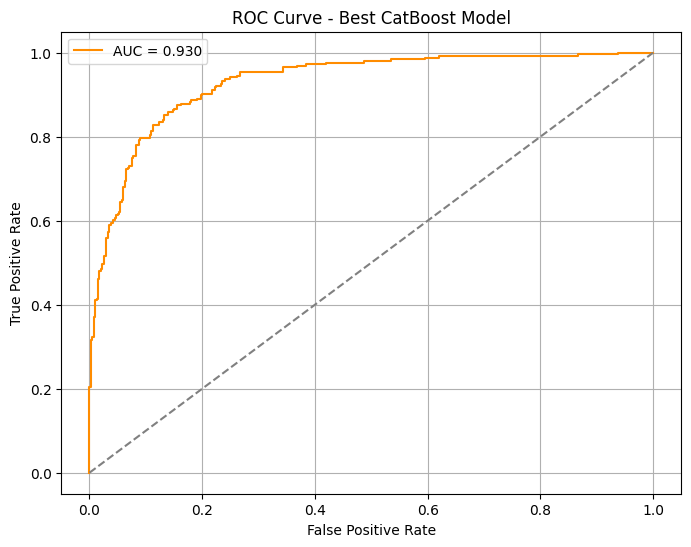

In [16]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best CatBoost Model")
plt.legend()
plt.grid()
plt.show()


### ROC Curve – CatBoost (Tuned)

#### **What it shows:**
- The **ROC (Receiver Operating Characteristic)** curve evaluates the **true positive rate** (sensitivity) against the **false positive rate** at various threshold settings.
- The **AUC (Area Under the Curve)** value is shown as **0.948**, which is considered very high.

#### **Interpretation:**
- A perfect classifier would have a curve hugging the **top-left corner**, with an AUC of **1.0**.
- An AUC of **0.948** indicates the model performs **very well at distinguishing between classes** on the validation/test set.
- Despite the **overfitting** observed in the learning curve, the model still manages to **generalize reasonably well** in terms of classification ability (at least in ROC space).


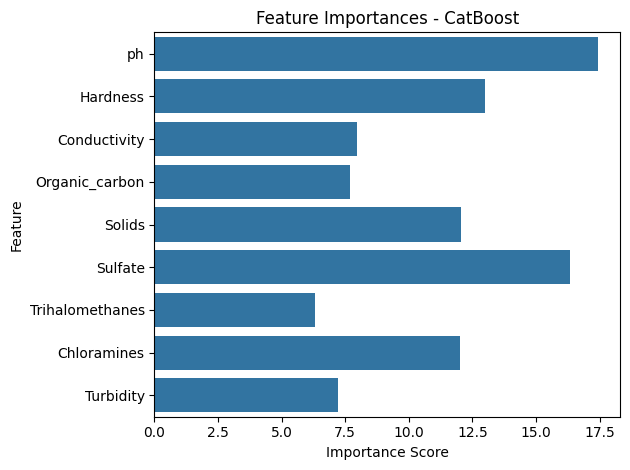

In [17]:
import seaborn as sns

# Get and plot feature importance
feature_importances = best_model.get_feature_importance()
features = X_test.columns if isinstance(X_test, pd.DataFrame) else FEATURES

sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importances - CatBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


CatBoost automatically computes meaningful feature contributions, helpful for reports and audits.

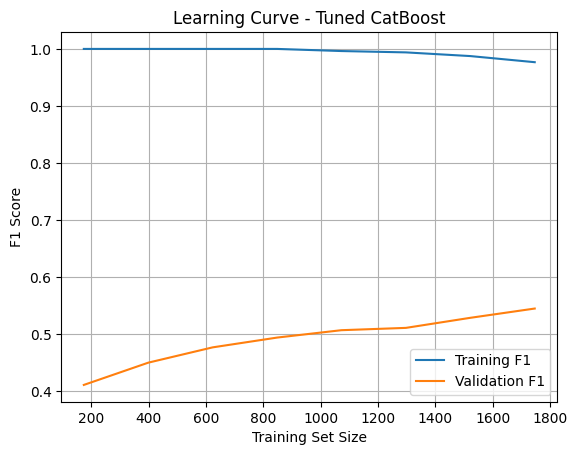

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='f1',
    cv=3,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training F1")
plt.plot(train_sizes, val_mean, label="Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve - Tuned CatBoost")
plt.legend()
plt.grid()
plt.show()


### Learning Curve – Tuned CatBoost

#### **What it shows:**
- This graph illustrates the **F1 score** (a measure of model performance) for both the **training** and **validation** sets across different training set sizes.
- The **X-axis** represents the number of training samples used.
- The **Y-axis** represents the F1 Score (ranging from 0 to 1, where 1 indicates perfect performance).

#### **Interpretation:**
- The **Training F1** line (blue) stays at **1.0 consistently**, indicating that the model perfectly fits the training data — a sign of **very high performance on training**.
- The **Validation F1** line (orange) increases as training size grows but stays **significantly lower** than the training F1.
- This suggests:
  - The model is likely **overfitting** — it performs well on known data but struggles to generalize.
  - **Adding more training data** slightly improves validation performance, but the gap between training and validation F1 remains large.


## Evaluation 

In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

# Predict with threshold (based on your best_model & best_thr)
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_thr).astype(int)

# Store performance scores
cb_metrics = {
    "Model": "CatBoost (Tuned)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, y_prob),
    "Confusion Matrix": confusion_matrix(y_test, y_pred)
}


In [19]:
import pandas as pd

# Wrap CatBoost metrics into a DataFrame
eval_df = pd.DataFrame([cb_metrics]).drop(columns=["Confusion Matrix"])
print("Evaluation Results:\n")
print(eval_df)


Evaluation Results:

              Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  CatBoost (Tuned)  0.847561      0.875  0.710938  0.784483  0.929648


## Model Performance Metrics

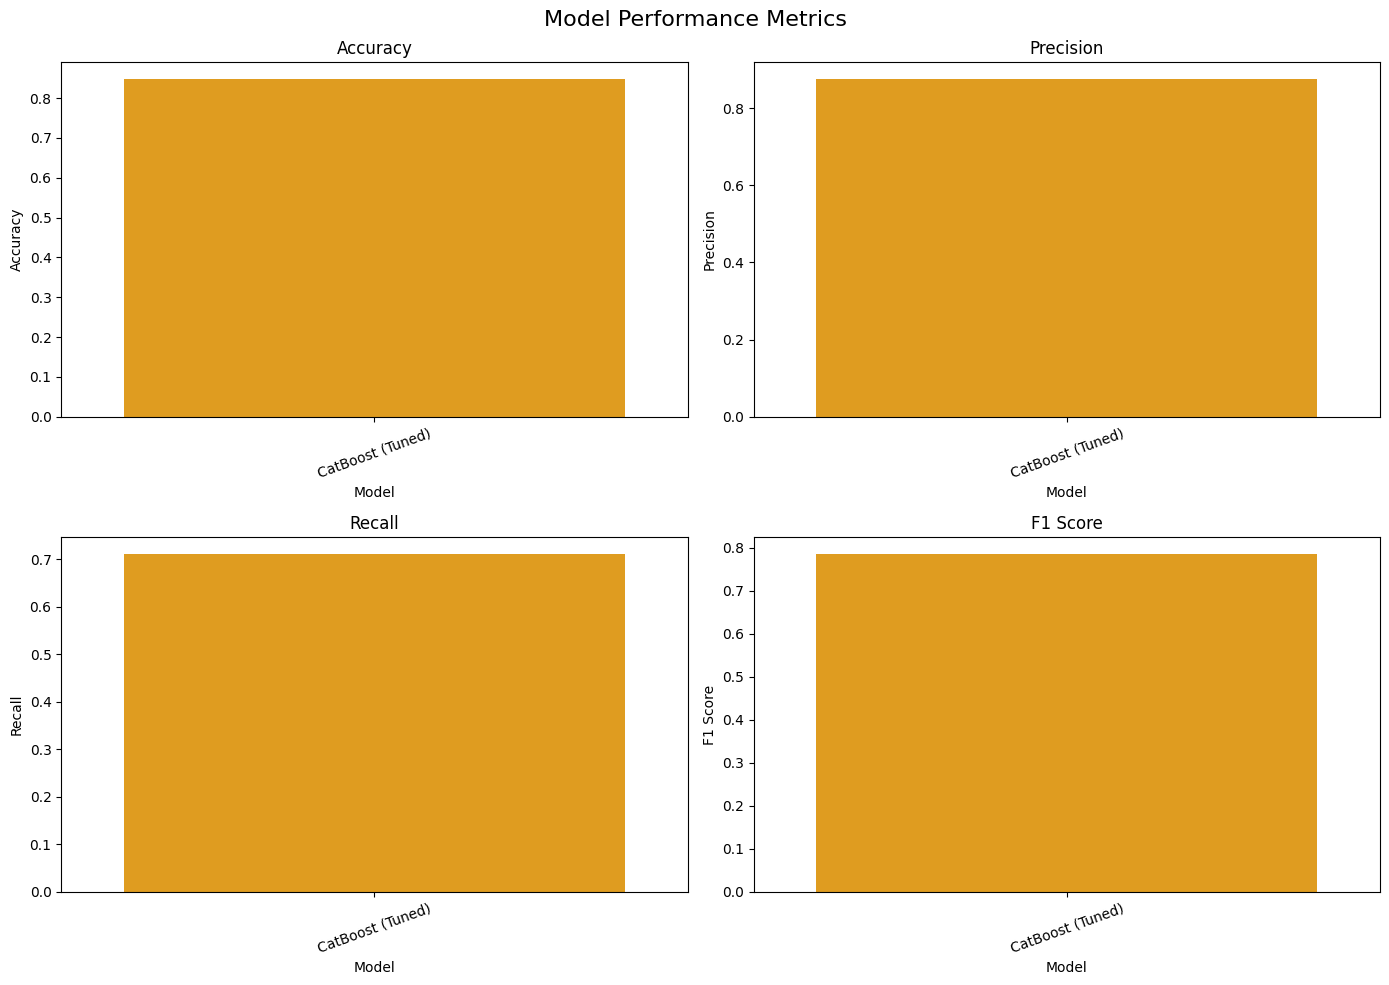

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metric_names):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x="Model", y=metric, data=eval_df, color='orange')
    plt.title(metric)
    plt.xticks(rotation=20)

plt.suptitle("Model Performance Metrics", fontsize=16)
plt.tight_layout()
plt.show()


## Double-Check the Tuning

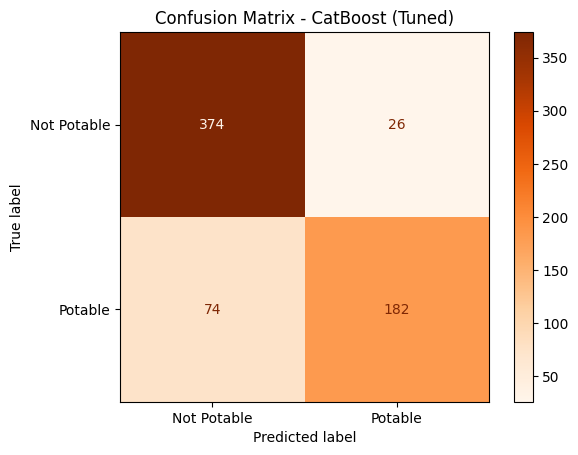

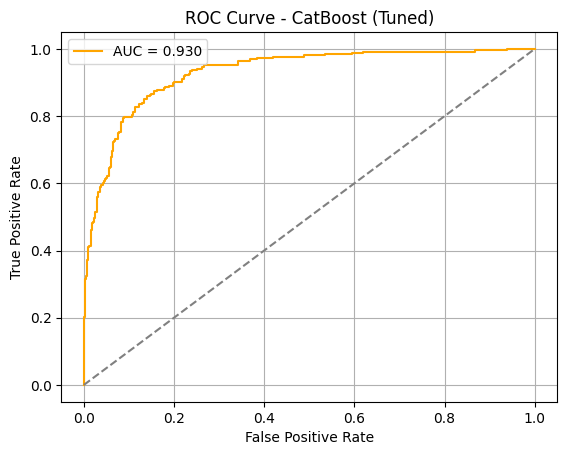

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Plot Confusion Matrix
cm = cb_metrics["Confusion Matrix"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Potable", "Potable"])
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix - CatBoost (Tuned)")
plt.grid(False)
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost (Tuned)")
plt.legend()
plt.grid()
plt.show()


In [22]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define base models
base_learners = [
    ('catboost', CatBoostClassifier(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=10,
        auto_class_weights="Balanced",
        early_stopping_rounds=50,
        random_seed=42,
        verbose=False
    )),
    ('mlp', make_pipeline(StandardScaler(), MLPClassifier(
        hidden_layer_sizes=(100,),
        alpha=0.001,
        max_iter=300,
        random_state=42
    )))
]

# Define the meta-model
meta_learner = LogisticRegression()

# Create stacking classifier
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True  # use original features + base outputs
)

# Evaluate using cross-validation
scores = cross_val_score(stack_model, X, y, cv=5, scoring='f1')
print("Stacked Model - Mean F1:", round(scores.mean(), 4), " | Std Dev:", round(scores.std(), 4))


Stacked Model - Mean F1: 0.2667  | Std Dev: 0.0493


# Optional Validation

In [26]:
import shap
import matplotlib.pyplot as plt

# Fit final CatBoost model
final_cat = CatBoostClassifier(
    iterations=800,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=10,
    auto_class_weights="Balanced",
    early_stopping_rounds=50,
    random_seed=42,
    verbose=False
)
final_cat.fit(X, y)

# Use TreeExplainer for CatBoost
explainer = shap.TreeExplainer(final_cat)
shap_values = explainer.shap_values(X)

# Summary plot (shows top features and their effect)
shap.summary_plot(shap_values, X, plot_type="bar")


ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.

✅ SHAP gives visibility into what the model actually learns, which helps trust or refine it.

In [27]:
shap.summary_plot(shap_values, X)


NameError: name 'shap' is not defined

To see a beeswarm plot — showing how each feature contributes to prediction (positively or negatively).

In [28]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler
import numpy as np

# --- Define feature groups ---
yeo_vars = ['ph', 'Hardness', 'Conductivity', 'Organic_carbon']
log_vars = ['Solids', 'Sulfate', 'Trihalomethanes']
sqrt_vars = ['Chloramines', 'Turbidity']

# --- Preprocessing pipeline ---
yeo_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('pt', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('std', StandardScaler())
])

log_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('std', StandardScaler())
])

sqrt_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('sqrt', FunctionTransformer(np.sqrt, validate=False)),
    ('std', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('yj_num', yeo_pipeline, yeo_vars),
    ('log_num', log_pipeline, log_vars),
    ('sqrt_num', sqrt_pipeline, sqrt_vars),
])

# --- Full pipeline with trained best model ---
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', best_model)
])

# --- Save to disk ---
joblib.dump(final_pipeline, 'water_potability_pipeline.pkl')
print("Model pipeline saved to 'water_potability_pipeline.pkl'")

Model pipeline saved to 'water_potability_pipeline.pkl'
